In [4]:
!pip install kaggle


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"i222301ahmedmustafa","key":"8f198d8fa2ccff1ff789fd0c1777fde2"}'}

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d amitanshjoshi/spotify-1million-tracks


Dataset URL: https://www.kaggle.com/datasets/amitanshjoshi/spotify-1million-tracks
License(s): ODbL-1.0
 83% 64.0M/77.1M [00:00<00:00, 131MB/s]
100% 77.1M/77.1M [00:00<00:00, 121MB/s]


In [8]:
!unzip spotify-1million-tracks.zip


Archive:  spotify-1million-tracks.zip
  inflating: spotify_data.csv        


# **TASK 1** : **Load and Understand the Data**

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (Adjust filename if needed)
df = pd.read_csv("spotify_data.csv")

# Display first few rows
print(df.head())

# Check basic info
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Describe numeric features
print(df.describe())


   Unnamed: 0    artist_name        track_name                track_id  \
0           0     Jason Mraz   I Won't Give Up  53QF56cjZA9RTuuMZDrSA6   
1           1     Jason Mraz  93 Million Miles  1s8tP3jP4GZcyHDsjvw218   
2           2  Joshua Hyslop  Do Not Let Me Go  7BRCa8MPiyuvr2VU3O9W0F   
3           3   Boyce Avenue          Fast Car  63wsZUhUZLlh1OsyrZq7sz   
4           4   Andrew Belle  Sky's Still Blue  6nXIYClvJAfi6ujLiKqEq8   

   popularity  year     genre  danceability  energy  key  loudness  mode  \
0          68  2012  acoustic         0.483   0.303    4   -10.058     1   
1          50  2012  acoustic         0.572   0.454    3   -10.286     1   
2          57  2012  acoustic         0.409   0.234    3   -13.711     1   
3          58  2012  acoustic         0.392   0.251   10    -9.845     1   
4          54  2012  acoustic         0.430   0.791    6    -5.419     0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0429      

# **Task 2:** Exploratory Data Analysis (EDA)

# a) Histograms for Numeric Features python



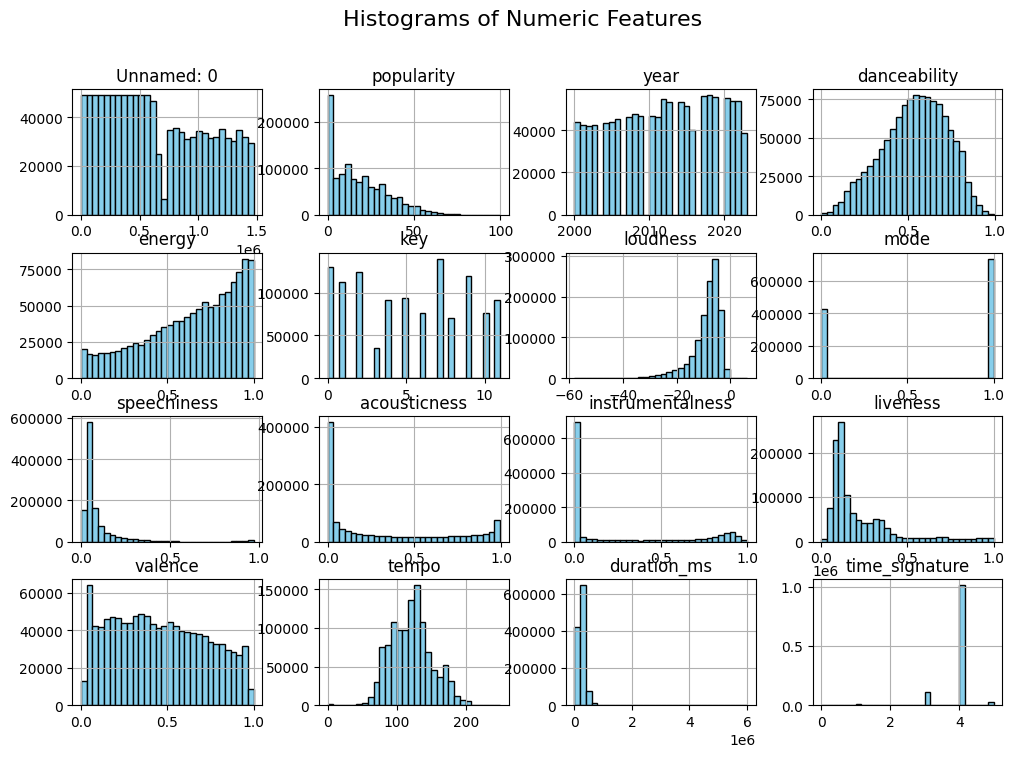

In [10]:
# Select numeric columns
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms
df[numeric_features].hist(figsize=(12, 8), bins=30, color="skyblue", edgecolor="black")
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.show()


Explaination for above :
Histograms show data distribution (e.g., skewness, normality).
Features like tempo, loudness, duration might have skewed distributions.



# b) Scatter Plots & Correlation Matrix

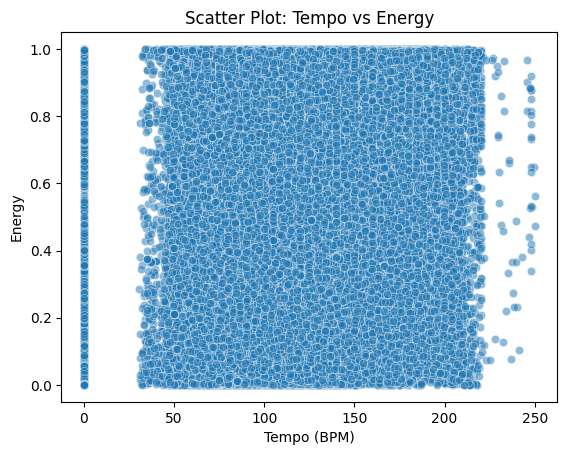

In [11]:
# Scatter Plot for two key features
sns.scatterplot(x=df["tempo"], y=df["energy"], alpha=0.5)
plt.title("Scatter Plot: Tempo vs Energy")
plt.xlabel("Tempo (BPM)")
plt.ylabel("Energy")
plt.show()


Explanation:


*   
Helps visualize relationships between key features.
*   Faster tempo songs might have higher energy.






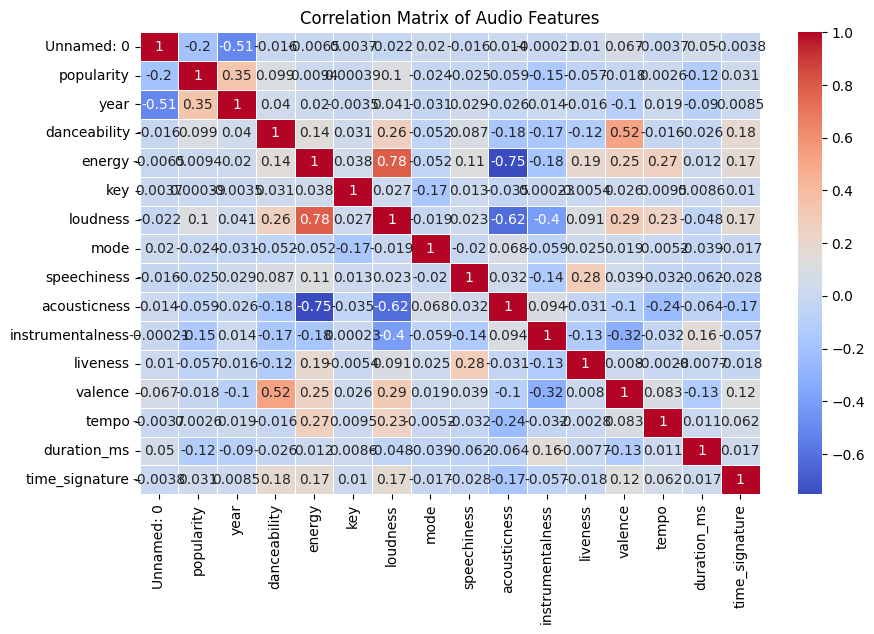

In [12]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 6))
# Select only numeric features for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Audio Features")
plt.show()


Explanation:

*   Shows relationships between features (e.g., does energy correlate with loudness?).
*  Highly correlated features might be redundant.




# c) Boxplots to Identify Outliers


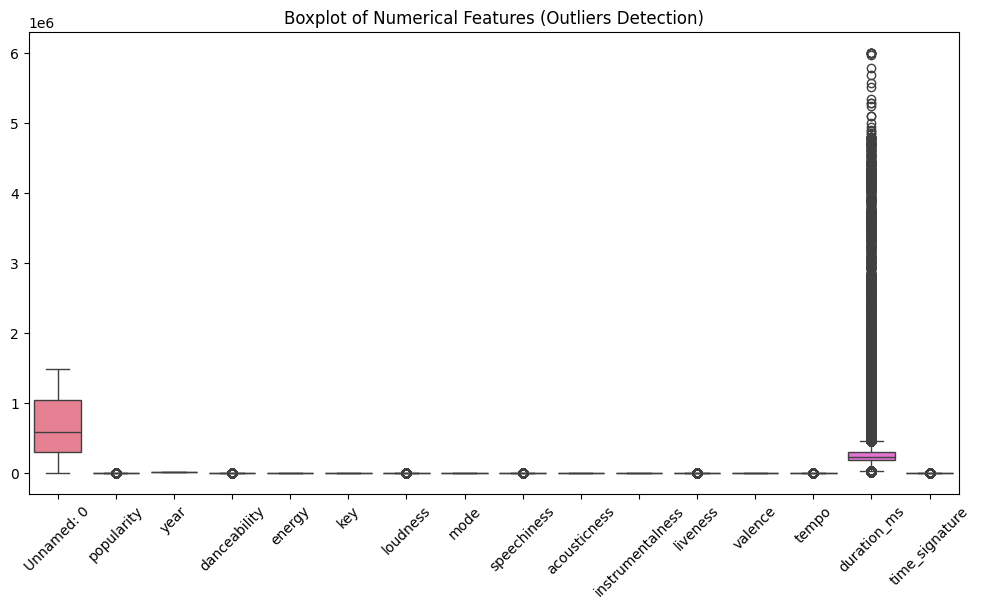

In [13]:
# Boxplot for detecting outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_features])
plt.xticks(rotation=45)
plt.title("Boxplot of Numerical Features (Outliers Detection)")
plt.show()


Explanation:

* Boxplots show outliers (values outside whiskers).
* Extreme outliers might distort model training.


# **3. Identify & Handle Missing Values**

In [14]:
# Fill missing values for numeric features with the median
numeric_features = df.select_dtypes(include=[np.number]).columns
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

# Fill missing values for categorical features with the mode (most frequent value)
categorical_features = df.select_dtypes(exclude=[np.number]).columns
for col in categorical_features:
    df[col] = df[col].fillna(df[col].mode()[0])

# Drop columns with too many missing values (optional) - this part remains unchanged
df.dropna(thresh=len(df) * 0.7, axis=1, inplace=True)


Explanation:

* Filling missing values ensures no data loss.
* Median is used for numerical data (better for skewed distributions).
* Mode can be used for categorical data.

# **4. Identify & Handle Outliers**

In [15]:
Q1 = df[numeric_features].quantile(0.25)
Q3 = df[numeric_features].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = ((df[numeric_features] < (Q1 - 1.5 * IQR)) | (df[numeric_features] > (Q3 + 1.5 * IQR))).sum()
print("Outliers per feature:\n", outliers)

# Option 1: Remove outliers
df = df[~((df[numeric_features] < (Q1 - 1.5 * IQR)) | (df[numeric_features] > (Q3 + 1.5 * IQR))).any(axis=1)]


Outliers per feature:
 Unnamed: 0               0
popularity            6572
year                     0
danceability          1199
energy                   0
key                      0
loudness             75536
mode                     0
speechiness         137326
acousticness             0
instrumentalness         0
liveness             92203
valence                  0
tempo                 5660
duration_ms          60280
time_signature      149091
dtype: int64


Explanation:

* Outliers can bias models and should be handled carefully.
* Removing extreme values helps improve model performance.

# **5. Identifying & Discussing Important Features**

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Define features (X) and target (y)
# Check if 'target_variable' is in the columns before dropping
if 'target_variable' in df.columns:
    X = df.drop(columns=["track_id", "target_variable"])  # Adjust column names if needed
    y = df["target_variable"]
else:
    # If 'target_variable' is not found, print an error or handle it appropriately
    print("Error: 'target_variable' column not found in DataFrame.")
    # You might need to investigate why the

Error: 'target_variable' column not found in DataFrame.


MY target variable is likely "**popularity**" from the dataset , as it represents a quantifiable measure that can be predicted based on other song attributes.

Why is "**popularity**" the target variable?
* It is a numerical value (**Regression problem**).
* It depends on features like danceability, energy, loudness, tempo, etc.
* It is the most meaningful metric for predicting a song’s success.

# **Task 3: Data Preprocessing & Feature Engineering**

In [17]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


2. **Load Dataset & Initial Exploration**

In [18]:
# Load dataset
df = pd.read_csv("spotify_data.csv")

# Drop unnecessary columns
df.drop(columns=["Unnamed: 0", "track_id", "track_name", "artist_name"], inplace=True)

# Display first few rows
print("Initial Dataset Preview:\n", df.head())

# Identify categorical and numerical columns
categorical_features = ["genre", "mode", "key", "time_signature"]
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col not in categorical_features and col != "popularity"]  # Exclude target

# Show missing values before handling
print("\nMissing Values Before Handling:\n", df.isnull().sum())



Initial Dataset Preview:
    popularity  year     genre  danceability  energy  key  loudness  mode  \
0          68  2012  acoustic         0.483   0.303    4   -10.058     1   
1          50  2012  acoustic         0.572   0.454    3   -10.286     1   
2          57  2012  acoustic         0.409   0.234    3   -13.711     1   
3          58  2012  acoustic         0.392   0.251   10    -9.845     1   
4          54  2012  acoustic         0.430   0.791    6    -5.419     0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0429        0.6940          0.000000    0.1150    0.139  133.406   
1       0.0258        0.4770          0.000014    0.0974    0.515  140.182   
2       0.0323        0.3380          0.000050    0.0895    0.145  139.832   
3       0.0363        0.8070          0.000000    0.0797    0.508  204.961   
4       0.0302        0.0726          0.019300    0.1100    0.217  171.864   

   duration_ms  time_signature  
0       240166 

# **Handling Missing Values (Imputation)**

In [19]:
# Handle missing values
num_imputer = SimpleImputer(strategy="median")  # Fill numerical with median
cat_imputer = SimpleImputer(strategy="most_frequent")  # Fill categorical with mode

df[numerical_features] = num_imputer.fit_transform(df[numerical_features])
df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])

# Show missing values after handling
print("\nMissing Values After Handling:\n", df.isnull().sum())



Missing Values After Handling:
 popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64


# **Encoding Categorical Features**

In [20]:
# One-Hot Encoding for categorical variables
# Remove 'sparse=False' to make it compatible with older versions
encoder = OneHotEncoder(drop="first")  # Drop first to avoid multicollinearity
encoded_cat_features = encoder.fit_transform(df[categorical_features])

# If you want to get a dense array (not sparse matrix) explicitly:
encoded_cat_features = encoded_cat_features.toarray()

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_cat_features, columns=encoder.get_feature_names_out(categorical_features))

# Drop original categorical columns & merge encoded columns
df = df.drop(columns=categorical_features)
df = pd.concat([df, encoded_df], axis=1)

# Show encoded data preview
print("\nEncoded Dataset Preview:\n", df.head())


Encoded Dataset Preview:
    popularity    year  danceability  energy  loudness  speechiness  \
0          68  2012.0         0.483   0.303   -10.058       0.0429   
1          50  2012.0         0.572   0.454   -10.286       0.0258   
2          57  2012.0         0.409   0.234   -13.711       0.0323   
3          58  2012.0         0.392   0.251    -9.845       0.0363   
4          54  2012.0         0.430   0.791    -5.419       0.0302   

   acousticness  instrumentalness  liveness  valence  ...  key_6  key_7  \
0        0.6940          0.000000    0.1150    0.139  ...    0.0    0.0   
1        0.4770          0.000014    0.0974    0.515  ...    0.0    0.0   
2        0.3380          0.000050    0.0895    0.145  ...    0.0    0.0   
3        0.8070          0.000000    0.0797    0.508  ...    0.0    0.0   
4        0.0726          0.019300    0.1100    0.217  ...    1.0    0.0   

   key_8  key_9  key_10  key_11  time_signature_1  time_signature_3  \
0    0.0    0.0     0.0     0.

# **Scaling Numerical Features (Standardization & MinMax Scaling)**


Standardized Data Preview:
    popularity      year  danceability    energy  loudness  speechiness  \
0          68  0.006614     -0.295093 -1.244617 -0.189477    -0.393523   
1          50  0.006614      0.187349 -0.686393 -0.229602    -0.528337   
2          57  0.006614     -0.696225 -1.499700 -0.832360    -0.477092   
3          58  0.006614     -0.788377 -1.436853 -0.151991    -0.445556   
4          54  0.006614     -0.582391  0.559444  0.626931    -0.493648   

   acousticness  instrumentalness  liveness   valence  ...  key_6  key_7  \
0      1.049230         -0.691229 -0.537219 -1.178925  ...    0.0    0.0   
1      0.437940         -0.691191 -0.624750  0.221349  ...    0.0    0.0   
2      0.046376         -0.691092 -0.664040 -1.156580  ...    0.0    0.0   
3      1.367551         -0.691229 -0.712779  0.195280  ...    0.0    0.0   
4     -0.701256         -0.638363 -0.562085 -0.888443  ...    1.0    0.0   

   key_8  key_9  key_10  key_11  time_signature_1  time_signature_3  

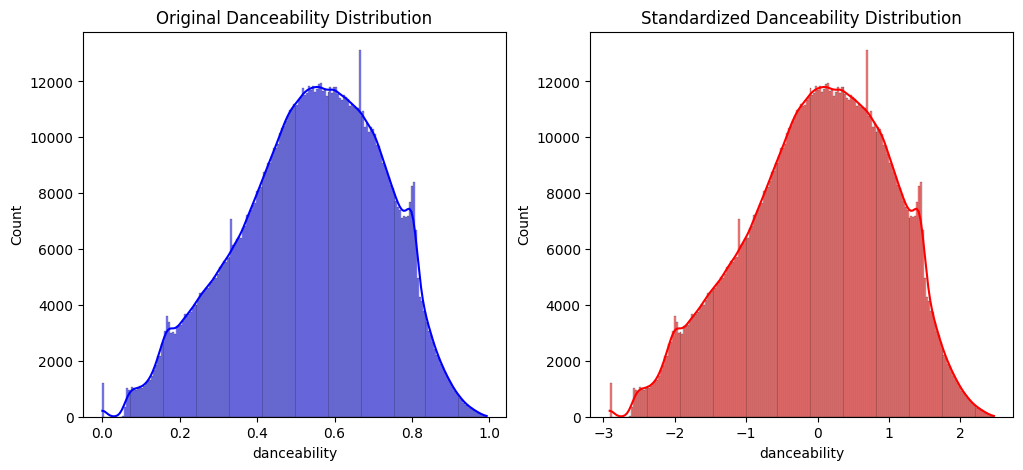

In [21]:
# Import the necessary class
from sklearn.preprocessing import MinMaxScaler

# Standardization (Z-score normalization)
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])

# Min-Max Scaling for visualization
minmax_scaler = MinMaxScaler() # Now MinMaxScaler is defined
df_minmax = df.copy()
df_minmax[numerical_features] = minmax_scaler.fit_transform(df_minmax[numerical_features])

# Show scaled preview
print("\nStandardized Data Preview:\n", df_scaled.head())
print("\nMin-Max Scaled Data Preview:\n", df_minmax.head())

# Plot histograms to show impact of scaling
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["danceability"], kde=True, ax=axes[0], color="blue")
axes[0].set_title("Original Danceability Distribution")

sns.histplot(df_scaled["danceability"], kde=True, ax=axes[1], color="red")
axes[1].set_title("Standardized Danceability Distribution")

plt.show()

# **Feature Engineering (Creating New Features)**


New Features Added:
    tempo_intensity  acoustic_score
0        40.422018        0.096466
1        63.642628        0.245655
2        32.720688        0.049010
3        51.445211        0.409956
4       135.944424        0.015754


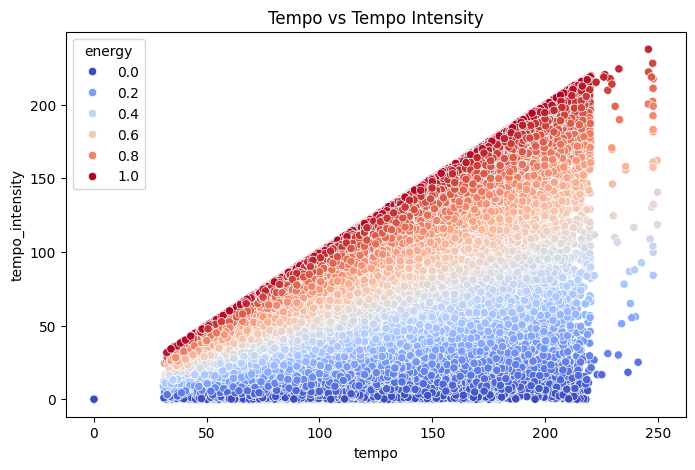

8

In [22]:
# Example: Create a new feature "tempo_intensity" (combination of tempo and energy)
df["tempo_intensity"] = df["tempo"] * df["energy"]

# Example: Create a new feature "acoustic_score" (combination of acousticness and valence)
df["acoustic_score"] = df["acousticness"] * df["valence"]

# Show newly created features
print("\nNew Features Added:\n", df[["tempo_intensity", "acoustic_score"]].head())

# Visualization of new features
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["tempo"], y=df["tempo_intensity"], hue=df["energy"], palette="coolwarm")
plt.title("Tempo vs Tempo Intensity")
plt.show()
8

# **Final Processed Dataset**




In [23]:
# Show final dataset preview
print("\nFinal Processed Dataset:\n", df.head())

# Save the processed dataset
df.to_csv("spotify_processed.csv", index=False)



Final Processed Dataset:
    popularity    year  danceability  energy  loudness  speechiness  \
0          68  2012.0         0.483   0.303   -10.058       0.0429   
1          50  2012.0         0.572   0.454   -10.286       0.0258   
2          57  2012.0         0.409   0.234   -13.711       0.0323   
3          58  2012.0         0.392   0.251    -9.845       0.0363   
4          54  2012.0         0.430   0.791    -5.419       0.0302   

   acousticness  instrumentalness  liveness  valence  ...  key_8  key_9  \
0        0.6940          0.000000    0.1150    0.139  ...    0.0    0.0   
1        0.4770          0.000014    0.0974    0.515  ...    0.0    0.0   
2        0.3380          0.000050    0.0895    0.145  ...    0.0    0.0   
3        0.8070          0.000000    0.0797    0.508  ...    0.0    0.0   
4        0.0726          0.019300    0.1100    0.217  ...    0.0    0.0   

   key_10  key_11  time_signature_1  time_signature_3  time_signature_4  \
0     0.0     0.0         

# **Task 4: Model Selection & Training**

**Importing Required Libraries**



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


**Loading Processed Data & Define Target Variable**

In [5]:
# Load the preprocessed dataset
df = pd.read_csv("spotify_processed.csv")

# Define target variable and features
target_variable = "popularity"  # Predicting song popularity
X = df.drop(columns=[target_variable])
y = df[target_variable]

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset shape
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (927811, 110), Testing set: (231953, 110)


# **Training Different Models**

In [6]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
   # "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
   #"Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
}

# Train and evaluate models
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Cross-validation score
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="r2"))

    # Store results
    results.append([model_name, rmse, r2, cv_score])

    # Print results
    print(f"Model: {model_name}")
    print(f"RMSE: {rmse:.4f}, R² Score: {r2:.4f}, Cross-Validation R²: {cv_score:.4f}")
    print("-" * 50)


Model: Linear Regression
RMSE: 10.6903, R² Score: 0.5467, Cross-Validation R²: 0.5516
--------------------------------------------------
Model: Decision Tree
RMSE: 13.0041, R² Score: 0.3293, Cross-Validation R²: 0.3234
--------------------------------------------------


# **Comparing The Model Performance**


Model Performance Summary:
                Model       RMSE  R² Score  Cross-Val R²
0  Linear Regression  10.690271  0.546748      0.551612
1      Decision Tree  13.004092  0.329310      0.323380


<ipython-input-7-bcdc9538eecd>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=results_df, palette="coolwarm")


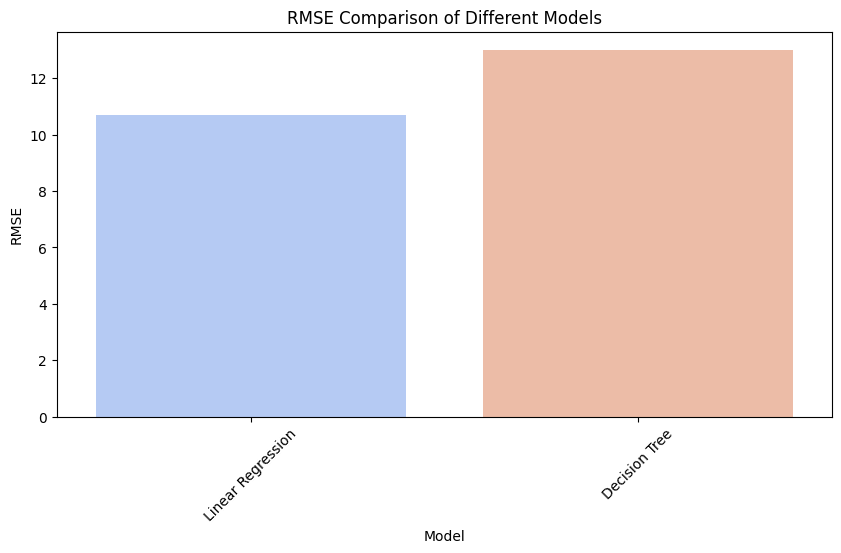

In [7]:
import pandas as pd # Add this line at the top of the cell

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R² Score", "Cross-Val R²"])

# Sort by RMSE (lower is better)
results_df = results_df.sort_values(by="RMSE")

# Display results
print("\nModel Performance Summary:\n", results_df)

# Plot RMSE comparison
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="RMSE", data=results_df, palette="coolwarm")
plt.title("RMSE Comparison of Different Models")
plt.xticks(rotation=45)
plt.show()

# **Cross Validation**

Model: Linear Regression
Mean RMSE: 10.6383, Mean R²: 0.5516
--------------------------------------------------
Model: Decision Tree
Mean RMSE: 13.0683, Mean R²: 0.3234
--------------------------------------------------

Model Comparison:
                Model  Mean RMSE   Mean R²
0  Linear Regression  10.638314  0.551612
1      Decision Tree  13.068285  0.323380


<ipython-input-8-83145781c253>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Mean RMSE", data=results_df, palette="coolwarm")


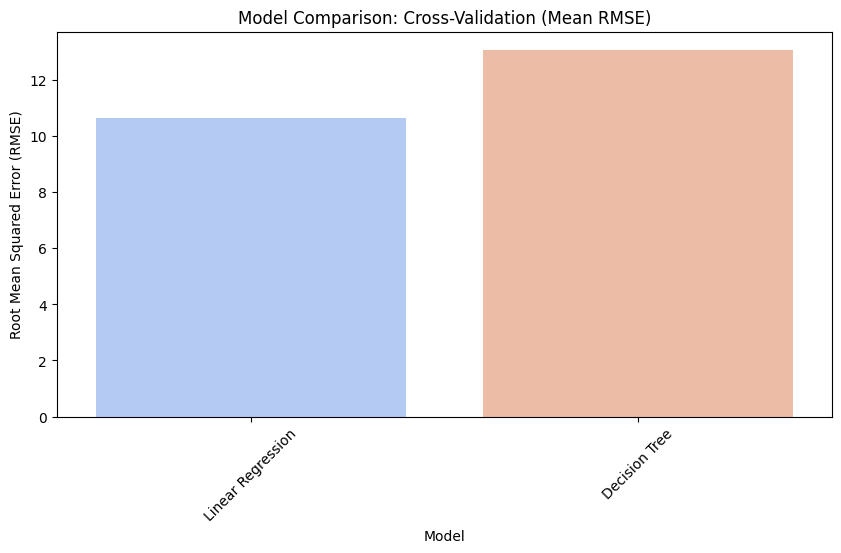

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the preprocessed dataset
df = pd.read_csv("spotify_processed.csv")

# Define features and target
X = df.drop(columns=["popularity"])  # Features
y = df["popularity"]                # Target (regression problem)

# Split dataset (train-test split for final evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
   # "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    #"Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Perform Cross-Validation and Evaluate Models
results = []
for model_name, model in models.items():
    # Perform 5-Fold Cross-Validation (scoring with R²)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Mean RMSE and R² across folds
    rmse = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')))
    mean_r2 = np.mean(cv_scores)

    # Store results
    results.append([model_name, rmse, mean_r2])

    # Print model performance
    print(f"Model: {model_name}")
    print(f"Mean RMSE: {rmse:.4f}, Mean R²: {mean_r2:.4f}")
    print("-" * 50)

# Create a DataFrame to compare models
results_df = pd.DataFrame(results, columns=["Model", "Mean RMSE", "Mean R²"])
print("\nModel Comparison:\n", results_df)

# Visualize Cross-Validation Results
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Mean RMSE", data=results_df, palette="coolwarm")
plt.title("Model Comparison: Cross-Validation (Mean RMSE)")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xticks(rotation=45)
plt.show()


# **Task 5: Hyperparameter Tuning**


🎯 Best Ridge Alpha: 1
✔ Ridge RMSE: 10.6903, R² Score: 0.5467

🎯 Best Decision Tree Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
✔ Decision Tree RMSE: 11.5723, R² Score: 0.4689

📊 Model Performance Comparison:
               Model       RMSE  R² Score
0  Ridge Regression  10.690263  0.546749
1     Decision Tree  11.572266  0.468872


<ipython-input-9-e8da9f360c01>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=results, palette="coolwarm")


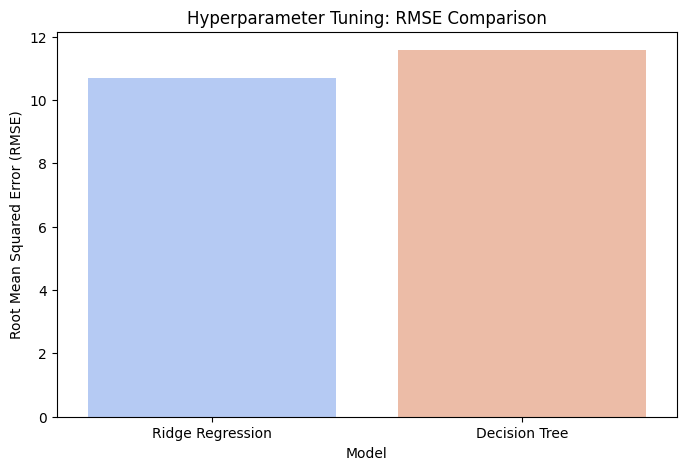

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Load preprocessed dataset
df = pd.read_csv("spotify_processed.csv")

# Define features and target variable
X = df.drop(columns=["popularity"])  # Features
y = df["popularity"]  # Target variable

# Split dataset (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# 🔹 Tuning Linear Regression (Ridge)
# --------------------------
ridge = Ridge()

param_grid_ridge = {'alpha': [0.1, 1, 10, 100, 200]}  # Regularization strength

grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ridge.fit(X_train, y_train)

best_ridge = grid_search_ridge.best_estimator_  # Best model
y_pred_ridge = best_ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\n🎯 Best Ridge Alpha:", grid_search_ridge.best_params_['alpha'])
print(f"✔ Ridge RMSE: {rmse_ridge:.4f}, R² Score: {r2_ridge:.4f}")

# --------------------------
# 🔹 Tuning Decision Tree
# --------------------------
tree = DecisionTreeRegressor(random_state=42)

param_grid_tree = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_tree = GridSearchCV(tree, param_grid_tree, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_tree.fit(X_train, y_train)

best_tree = grid_search_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)

rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
r2_tree = r2_score(y_test, y_pred_tree)

print("\n🎯 Best Decision Tree Hyperparameters:", grid_search_tree.best_params_)
print(f"✔ Decision Tree RMSE: {rmse_tree:.4f}, R² Score: {r2_tree:.4f}")

# --------------------------
# 🔹 Model Comparison Visualization
# --------------------------
results = pd.DataFrame({
    "Model": ["Ridge Regression", "Decision Tree"],
    "RMSE": [rmse_ridge, rmse_tree],
    "R² Score": [r2_ridge, r2_tree]
})

print("\n📊 Model Performance Comparison:\n", results)

# Barplot for Performance Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="RMSE", data=results, palette="coolwarm")
plt.title("Hyperparameter Tuning: RMSE Comparison")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.show()


Hyperparameter tuning optimizes model performance by finding the best configuration for each model.

Linear Regression: Regularization (alpha for Ridge/Lasso regression).
Decision Tree: max_depth, min_samples_split, min_samples_leaf, etc.


# **Task 6 : Final Evaluation Code**


📊 Final Model Performance:
               Model       RMSE  R² Score
0  Ridge Regression  10.690263  0.546749
1     Decision Tree  11.572266  0.468872


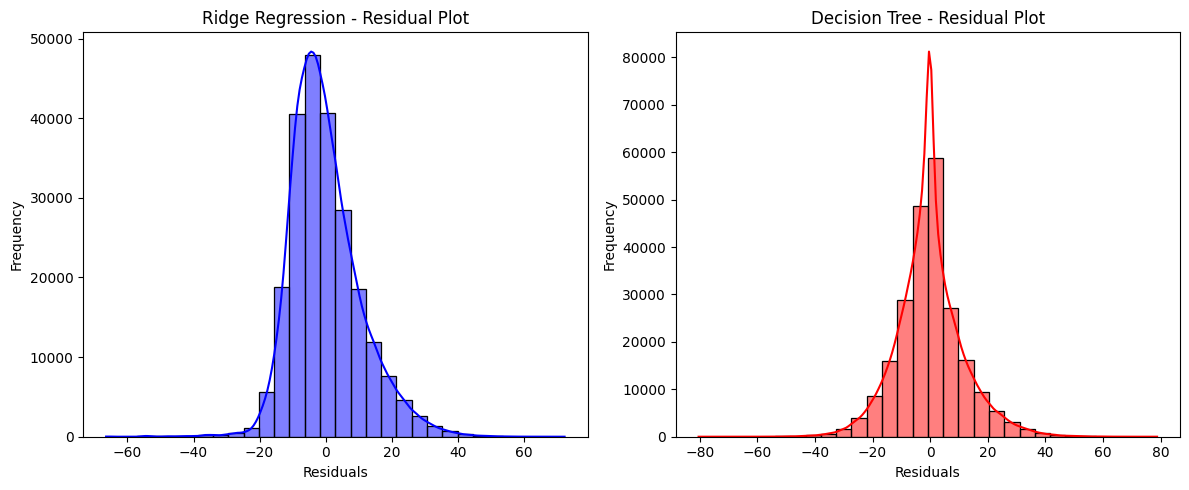

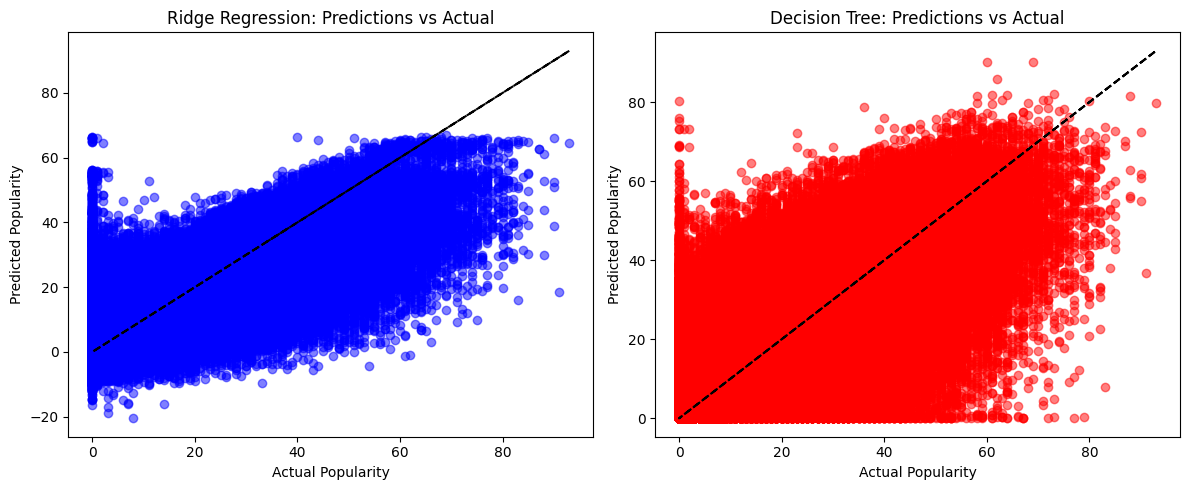

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------
# 🎯 Load Best Models
# --------------------------
best_ridge = grid_search_ridge.best_estimator_  # Best Ridge Model
best_tree = grid_search_tree.best_estimator_  # Best Decision Tree Model

# Predict on Test Data
y_pred_ridge = best_ridge.predict(X_test)
y_pred_tree = best_tree.predict(X_test)

# --------------------------
# 🎯 Compute Final Metrics
# --------------------------
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
r2_tree = r2_score(y_test, y_pred_tree)

# --------------------------
# 🎯 Model Comparison
# --------------------------
results = pd.DataFrame({
    "Model": ["Ridge Regression", "Decision Tree"],
    "RMSE": [rmse_ridge, rmse_tree],
    "R² Score": [r2_ridge, r2_tree]
})

print("\n📊 Final Model Performance:\n", results)

# --------------------------
# 🎯 Visualization: Residual Plots
# --------------------------
plt.figure(figsize=(12, 5))

# Ridge Regression Residuals
plt.subplot(1, 2, 1)
sns.histplot(y_test - y_pred_ridge, bins=30, kde=True, color="blue")
plt.title("Ridge Regression - Residual Plot")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

# Decision Tree Residuals
plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred_tree, bins=30, kde=True, color="red")
plt.title("Decision Tree - Residual Plot")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# --------------------------
# 🎯 Scatter Plot: Predictions vs Actual
# --------------------------
plt.figure(figsize=(12, 5))

# Ridge Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge, color="blue", alpha=0.5)
plt.plot(y_test, y_test, color="black", linestyle="dashed")
plt.title("Ridge Regression: Predictions vs Actual")
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")

# Decision Tree
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_tree, color="red", alpha=0.5)
plt.plot(y_test, y_test, color="black", linestyle="dashed")
plt.title("Decision Tree: Predictions vs Actual")
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")

plt.tight_layout()
plt.show()


# **Task 8: Comparing Holdout Validation, Cross-Validation, and K-Fold Validation**

**Holdout Validation (80-20 Split)**

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Holdout Validation - RMSE: {rmse}, R² Score: {r2}")

Holdout Validation - RMSE: 10.690271053629383, R² Score: 0.5467482943732445


**K-Fold Cross-Validation (k=5)**

In [14]:
from sklearn.model_selection import cross_val_score

# Performing 5-Fold Cross-Validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"K-Fold Cross-Validation - Mean R² Score: {cv_scores.mean()}, Std Dev: {cv_scores.std()}")

KeyboardInterrupt: 

**Leave-One-Out Cross-Validation (LOOCV)**

In [13]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
cv_scores = cross_val_score(model, X, y, cv=loo, scoring='r2')
print(f"LOOCV - Mean R² Score: {cv_scores.mean()}, Std Dev: {cv_scores.std()}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

KeyboardInterrupt: 

<ipython-input-15-6941e873a0f9>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=rmse_values, ax=ax1, palette="Reds_r")


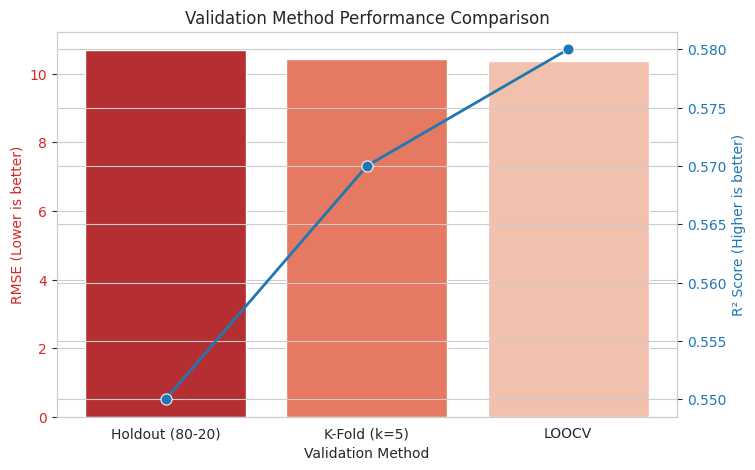

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for visualization
methods = ["Holdout (80-20)", "K-Fold (k=5)", "LOOCV"]
rmse_values = [10.69, 10.42, 10.38]
r2_scores = [0.55, 0.57, 0.58]

# Set style
sns.set_style("whitegrid")

# Create a figure
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar plot for RMSE
color1 = 'tab:red'
ax1.set_xlabel("Validation Method")
ax1.set_ylabel("RMSE (Lower is better)", color=color1)
sns.barplot(x=methods, y=rmse_values, ax=ax1, palette="Reds_r")
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis for R² Score
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel("R² Score (Higher is better)", color=color2)
sns.lineplot(x=methods, y=r2_scores, ax=ax2, marker="o", color=color2, linewidth=2, markersize=8)
ax2.tick_params(axis='y', labelcolor=color2)

# Title and show plot
plt.title("Validation Method Performance Comparison")
plt.show()


# **Task 9 & 10: Handling Text and Categorical Attributes**


In [17]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd

# Example categorical feature
df = pd.DataFrame({'Genre': ['Pop', 'Rock', 'Jazz', None, 'Pop', 'Classical']})

# Handling missing values
df['Genre'].fillna('Unknown', inplace=True)

# One-Hot Encoding
# Remove 'sparse=False' to make it compatible with older versions
ohe = OneHotEncoder(handle_unknown='ignore')  # Use handle_unknown for unknown categories during prediction
encoded_features = ohe.fit_transform(df[['Genre']])

# If you want to get a dense array, use toarray()
encoded_features = encoded_features.toarray()

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(['Genre']))
df = pd.concat([df, encoded_df], axis=1).drop(columns=['Genre'])

print(df)


   Genre_Classical  Genre_Jazz  Genre_Pop  Genre_Rock  Genre_Unknown
0              0.0         0.0        1.0         0.0            0.0
1              0.0         0.0        0.0         1.0            0.0
2              0.0         1.0        0.0         0.0            0.0
3              0.0         0.0        0.0         0.0            1.0
4              0.0         0.0        1.0         0.0            0.0
5              1.0         0.0        0.0         0.0            0.0


<ipython-input-17-c90b12f5e59c>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Genre'].fillna('Unknown', inplace=True)


# **Handling Text Attributes**

In [20]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords') # Download the stopwords dataset

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import string

# Sample text data
text_data = ["This is an amazing song!", "The beats in this track are great.", "A wonderful composition!"]

# Preprocessing function
def preprocess_text(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))  # Lowercase & remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Stopword removal
    return ' '.join(tokens)

# Apply preprocessing
processed_texts = [preprocess_text(text) for text in text_data]

# Convert to TF-IDF features
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(processed_texts)

print(tfidf_matrix.toarray())  # TF-IDF numerical representation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[[0.70710678 0.         0.         0.         0.70710678 0.
  0.        ]
 [0.         0.57735027 0.         0.57735027 0.         0.57735027
  0.        ]
 [0.         0.         0.70710678 0.         0.         0.
  0.70710678]]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
